In [1]:
import os
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOAgent
from neurocuts_env import NeuroCutsEnv
from run_neurocuts import on_episode_end
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from mask import PartitionMaskModel

%matplotlib inline

In [2]:
### Init ###
rules = os.path.abspath("classbench/{}".format("acl5_1k"))
dump_dir = "/tmp/neurocuts_out"
reward_shape = "linear"

ray.init()

2019-03-10 10:29:09,535	INFO node.py:278 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-03-10_10-29-09_47783/logs.
2019-03-10 10:29:09,646	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:10777 to respond...
2019-03-10 10:29:09,761	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:24351 to respond...
2019-03-10 10:29:09,765	INFO services.py:798 -- Starting Redis shard with 10.0 GB max memory.
2019-03-10 10:29:09,784	INFO services.py:1360 -- Starting the Plasma object store with 6.871947672999999 GB memory using /tmp.



View the web UI at http://localhost:8895/notebooks/ray_ui.ipynb?token=75db57aa64fcd9c7b35964082add8f645f456cb9a6a6dd98



{'node_ip_address': None,
 'redis_address': '192.168.0.102:10777',
 'object_store_address': '/tmp/ray/session_2019-03-10_10-29-09_47783/sockets/plasma_store',
 'webui_url': 'http://localhost:8895/notebooks/ray_ui.ipynb?token=75db57aa64fcd9c7b35964082add8f645f456cb9a6a6dd98',
 'raylet_socket_name': '/tmp/ray/session_2019-03-10_10-29-09_47783/sockets/raylet'}

In [3]:
### Setup ###
register_env(
    "tree_env", lambda env_config: NeuroCutsEnv(
        env_config["rules"],
        max_depth=env_config["max_depth"],
        max_actions_per_episode=env_config["max_actions"],
        dump_dir=env_config["dump_dir"],
        depth_weight=env_config["depth_weight"],
        reward_shape=env_config["reward_shape"],
        partition_mode=env_config["partition_mode"]))
ModelCatalog.register_custom_model("mask", PartitionMaskModel)

config =  {
        "num_gpus": 0,
        "num_workers": 3,
        "sgd_minibatch_size": 100,
        "sample_batch_size": 200,
        "train_batch_size": 1000,
        "batch_mode": "complete_episodes",
        "observation_filter": "NoFilter",
        "model": {
            "custom_model": "mask",
            "fcnet_hiddens": [512, 512],
        },
        "vf_share_layers": True,
        "entropy_coeff": 0.01,
        "callbacks": {
            "on_episode_end": tune.function(on_episode_end),
        },
        "env_config": {
            "dump_dir": dump_dir,
            "partition_mode": None,
            "reward_shape": reward_shape,
            "max_depth": 100,
            "max_actions": 1000,
            "depth_weight": 1.0,
            "rules": rules,
        },
    }

In [16]:
# file = "/Users/yitianzou/ray_results/neurocuts_None/PPO_tree_env_1_rules=_Users_yitianzou_neurocuts-code_classbench_acl5_1k,sample_batch_size=400_2019-02-20_15-30-42uewkqv_l/checkpoint_1/checkpoint-1"
# env = NeuroCutsEnv(rules_file="classbench/acl5_1k")
# agent = PPOAgent(env="tree_env", config=config)
# agent.restore(file)

In [15]:
directory = "/Users/yitianzou/ray_results/neurocuts_None/PPO_tree_env_0_2019-03-08_23-48-42pb2k3nsd"
env = NeuroCutsEnv(rules_file="classbench/acl5_1k")
agent_1 = PPOAgent(env="tree_env", config=config)
agent_1.restore(directory+"/checkpoint_1/checkpoint-1")
agent_25 = PPOAgent(env="tree_env", config=config)
agent_25.restore(directory+"/checkpoint_25/checkpoint-25")
agent_50 = PPOAgent(env="tree_env", config=config)
agent_50.restore(directory+"/checkpoint_50/checkpoint-50")
agent_75 = PPOAgent(env="tree_env", config=config)
agent_75.restore(directory+"/checkpoint_75/checkpoint-75")

2019-03-10 10:40:22,427	INFO policy_evaluator.py:264 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2019-03-10 10:40:23,227	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
2019-03-10 10:40:26,198	INFO policy_evaluator.py:264 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2019-03-10 10:40:27,426	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
2019-03-10 10:40:33,047	INFO policy_evaluator.py:264 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2019-03-10 10:40:33,995	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
2019-03-10 10:40:37,296	INFO policy_evaluator.py:264 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2019-03-10 10:40:38,110	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']


In [7]:
meta = directory + "/checkpoint_75/checkpoint-75.tune_metadata"
with open(meta, 'rb') as f:
    text = pickle.load(f)
print(text)

{'experiment_id': 'efc666193a144ec68611143aa650397c', 'iteration': 75, 'timesteps_total': 100214, 'time_total': 997.3804183006287, 'episodes_total': 1145, 'saved_as_dict': False}


## TODOS
1. Verify that after num-fast # iterations, reward (memory_access) has converged to around 10 - DONE
2. Generate distribution of (src, dst) - DONE
3. Make contour for 1st checkpoint - DONE
4. Vectorize _value - DONE
5. Get checkpoints + run for different ones - DONE
6. Try different initializations of other bits in real_obs
7. Random vector projection?

In [8]:
def make_binary_list(num):
    b = "{0:b}".format(int(num))
    lst = [float(d) for d in b]
    diff = 32 - len(lst)
    lst = [0.0]*diff + lst
    return lst
def make_dec(ip):
    ip_str = ''.join(str(int(e)) for e in ip)
    ip_dec = int(ip_str, 2)
    return ip_dec
i = 37
b = make_binary_list(i)
print(b)
print(make_dec(b))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
37


In [19]:
### Generate (X, Y) grid of obs ###
# max_ip = math.pow(2, 32)
# interval = 2**23
# X = np.arange(0, max_ip, interval)
# Y = np.arange(0, max_ip, interval)
# N = len(X)
# print(N)

# obs_lst = []

# for i in range(N):
#     for j in range(N):
#         src = make_binary_list(X[i])
#         dst = make_binary_list(Y[j])
#         size = 279 - 64
#         mask = [0.0] * size
#         real_obs = src + dst + mask
#         action_mask = [0.0] * 10
#         obs = {"real_obs": real_obs, "action_mask": action_mask}
#         _obs = agent.local_evaluator.preprocessors["default"].transform(obs)
#         obs_lst.append(_obs)
# print(obs_lst[0])

In [20]:
### Get values ###
def value(policy, obs):
    feed_dict = {
       policy.observations: obs,
    }
    vf = policy.sess.run(policy.value_function, feed_dict)
    return vf

# values_lst = value(agent.get_policy(), obs_lst)
# values = values_lst.reshape((N, N))
# print(values[30][30])

In [35]:
def generate_obs_and_vals(agent, mask=None):
    max_ip = math.pow(2, 32)
    interval = 2**23
    X = np.arange(0, max_ip, interval)
    Y = np.arange(0, max_ip, interval)
    N = len(X)

    obs_lst = []

    for i in range(N):
        for j in range(N):
            src = make_binary_list(X[i])
            dst = make_binary_list(Y[j])
            size = 279 - 64
            if mask is None:
                mask = [0.0] * size
            real_obs = src + dst + mask
            action_mask = [0.0] * 10
            obs = {"real_obs": real_obs, "action_mask": action_mask}
            _obs = agent.local_evaluator.preprocessors["default"].transform(obs)
            obs_lst.append(_obs)
    
    values_lst = value(agent.get_policy(), obs_lst)
    values = values_lst.reshape((N, N))
    return X, Y, values

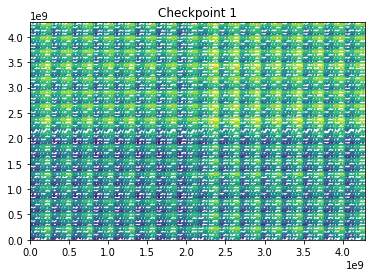

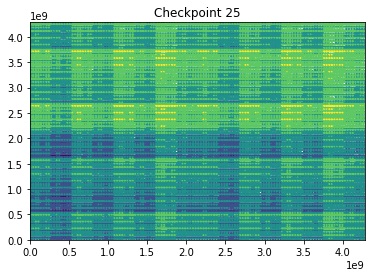

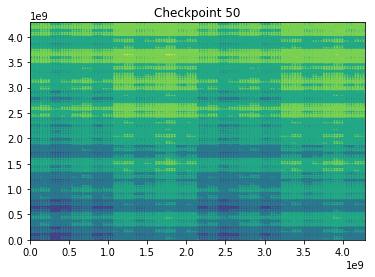

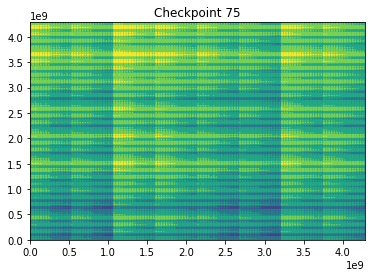

In [38]:
### Visualize ###
def visualize(agent, num, mask):
    X, Y, values = generate_obs_and_vals(agent, mask)
    _X, _Y = np.meshgrid(X, Y)
    plt.contour(_X, _Y, values)
    plt.title("Checkpoint {}".format(num))
    plt.show()
    
# mask = np.random.randint(2, size=215).tolist()
mask = None
visualize(agent_1, 1, mask)
visualize(agent_25, 25, mask)
visualize(agent_50, 50, mask)
visualize(agent_75, 75, mask)

# Yellow = high
# Green = medium
# Blue = low